In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Table of contents 

- Predictions of day-to-day values 
    - Module temperature from ambient temperature and irradiation
- Predictions of time series  

## First model analysis

### Predictions of day-to-day values - Module temperature from ambient temperature and irradiation
- INPUT: Irradiation & Ambient temp
- OUTPUT: Module Temp
- GRANULARITY: 
    - Meaned time (grouped by)
    - Each day & time


In [6]:
p1_Sensor = pd.read_csv("dataset/Plant_1_Weather_Sensor_Data.csv")
p1_Sensor = p1_Sensor.drop(columns=['SOURCE_KEY', 'PLANT_ID'])
p1_Sensor['DATETIME'] = pd.to_datetime(p1_Sensor['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
p1_Sensor['TIME'] = p1_Sensor['DATETIME'].dt.time
p1_meanedTime = p1_Sensor.groupby('TIME')[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']].mean().reset_index()
p1_meanedTime['TIME_ID']= [x for x in range(p1_meanedTime.shape[0])]

time_df = p1_meanedTime[['TIME','TIME_ID']]
p1_Sensor = time_df.merge(p1_Sensor, on='TIME')
p1_Sensor= p1_Sensor[['TIME_ID', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]

p2_Sensor = pd.read_csv("dataset/Plant_2_Weather_Sensor_Data.csv")
p2_Sensor = p2_Sensor.drop(columns=['SOURCE_KEY', 'PLANT_ID'])
p2_Sensor['DATETIME'] = pd.to_datetime(p2_Sensor['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
p2_Sensor['TIME'] = p2_Sensor['DATETIME'].dt.time
p2_Sensor = time_df.merge(p2_Sensor, on='TIME')
p2_meanedTime = p2_Sensor.groupby('TIME')[['TIME_ID', 'AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']].mean().reset_index()
p2_Sensor= p2_Sensor[['TIME_ID', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]


c:\Users\Shadow\anaconda3\envs\tgpu\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


EVAL:
- MAE: 0.7680437751501853
- MSE: 1.7713211911573667
- R2: 0.9795806689225554

TEST:
- MAE: 1.3843636370788026
- MSE: 3.257269376641742
- R2: 0.9735792231094961



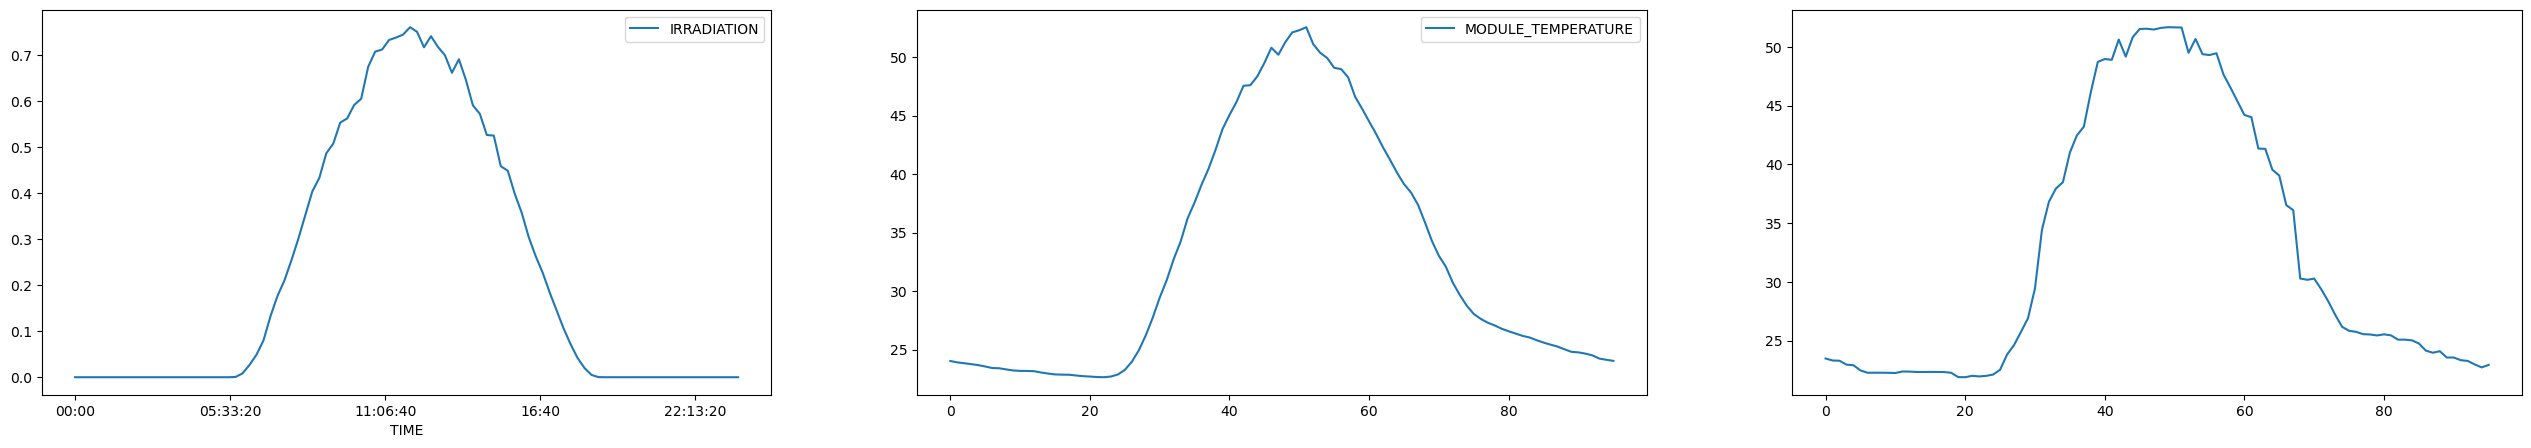

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

X = p1_meanedTime[['TIME_ID', 'AMBIENT_TEMPERATURE','IRRADIATION']]
Y = p1_meanedTime[['MODULE_TEMPERATURE']]
train_x, eval_x, train_y, eval_y = train_test_split(X,Y,test_size=0.25, random_state=42)

forest_regressor = RandomForestRegressor()
forest_regressor.fit(train_x, train_y)
predicted_values = forest_regressor.predict(eval_x)

pred_mae = mean_absolute_error(predicted_values,eval_y)
pred_mse = mean_squared_error(predicted_values,eval_y)
pred_r2 = r2_score(predicted_values,eval_y)

print("EVAL:\n- MAE: {}\n- MSE: {}\n- R2: {}\n".format(pred_mae, pred_mse, pred_r2))

test_x = p2_meanedTime[['TIME_ID', 'AMBIENT_TEMPERATURE','IRRADIATION']]
test_y = p2_meanedTime[['MODULE_TEMPERATURE']]

predicted_values = forest_regressor.predict(test_x)

pred_mae = mean_absolute_error(predicted_values,test_y)
pred_mse = mean_squared_error(predicted_values,test_y)
pred_r2 = r2_score(predicted_values,test_y)

print("TEST:\n- MAE: {}\n- MSE: {}\n- R2: {}\n".format(pred_mae, pred_mse, pred_r2))

fig, axes = plt.subplots(nrows=1, ncols=3)
p1_meanedTime.plot(x='TIME', y='IRRADIATION', ax=axes[0])
test_y.plot(ax=axes[1], figsize=(32,5))
axes[2].plot([i for i in range(len(predicted_values))], predicted_values)

Even if the values are pretty much around expected ones, the curve is a coarser one than the expected one but still follow the schema.

Has we only have 1 entry for each time, using RandomForest for this tasks is not really useful but can give a first glance of we we could do.

##### Each day & time

Now we'll be using all days and times to get more data for training which will give more example and instance to feed ourt model.

**Remark:** I'm fully aware that each day is different and production can widely differ from a day to another, but since lots of parameters influencing this aren't available, only the time, irradiation and temp will be used.


In [4]:
X, Y = p1_Sensor[['TIME_ID', 'AMBIENT_TEMPERATURE','IRRADIATION']], p1_Sensor[['MODULE_TEMPERATURE']]
train_x, eval_x, train_y, eval_y = train_test_split(X,Y,test_size=0.25, random_state=42)
test_x, test_y = p2_Sensor[['TIME_ID', 'AMBIENT_TEMPERATURE','IRRADIATION']], p2_Sensor[['MODULE_TEMPERATURE']]


forest_regressor = RandomForestRegressor(
    n_estimators=100, 
    criterion='squared_error',
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=1.0, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True,
    oob_score=False, 
    n_jobs=None, 
    random_state=None, 
    verbose=0, 
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
) 
forest_regressor.fit(train_x, train_y)

eval_values = forest_regressor.predict(eval_x)
print("EVAL:\n- MAE: {}\n- MSE: {}\n- R2: {}\n".format(
    mean_absolute_error(eval_values,eval_y), 
    mean_squared_error(eval_values,eval_y), 
    r2_score(eval_values,eval_y)
    ))

test_values = forest_regressor.predict(test_x)
print("TEST:\n- MAE: {}\n- MSE: {}\n- R2: {}\n".format(
    mean_absolute_error(test_values,test_y), 
    mean_squared_error(test_values,test_y), 
    r2_score(test_values,test_y)
    ))

c:\Users\Shadow\anaconda3\envs\tgpu\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


EVAL:
- MAE: 1.0550731526854489
- MSE: 2.8963095817596916
- R2: 0.980500939656033

TEST:
- MAE: 2.1800135773531486
- MSE: 10.021401545982096
- R2: 0.940967470734929



Shallow Fine tuning for better accuracy

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


forest_regressor = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

grid_search = GridSearchCV(estimator=forest_regressor, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
# grid_search.fit(train_x, train_y)

print("Grid")
print(grid_search.best_params_)
print(grid_search.best_estimator_)

# test_values = forest_regressor.predict(test_x)
# print("TEST:\n- MAE: {}\n- MSE: {}\n- R2: {}\n".format(
#     mean_absolute_error(test_values,test_y), 
#     mean_squared_error(test_values,test_y), 
#     r2_score(test_values,test_y)
#     ))

# test_y.plot()
# plt.plot([i for i in range(len(test_values))], test_values)

Grid


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

GridsearchCV best params found for RandomForest: 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500

In [ ]:
from sklearn.svm import SVR

svm_regressor=SVR()
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}
# svm_regressor.fit(train_x, train_y)
# svmGrid = GridSearchCV(svm_regressor, param_grid, n_jobs=-1)
# svmGrid.fit(eval_x, eval_y)
# print(svmGrid.best_params_)

c:\Users\Shadow\anaconda3\envs\tgpu\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Shadow\anaconda3\envs\tgpu\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}


Trying different "basics" boosting methods

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(train_x, train_y)

print("R2 train: {}".format(gbr.score(train_x, train_y)))
print("R2 train: {}".format(gbr.score(eval_x, eval_y)))

params = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': np.arange(3, 11),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'max_features': ['sqrt', 'log2', None]    
}
search = RandomizedSearchCV(GradientBoostingRegressor(random_state=0), params, n_iter=50, n_jobs=-1)
search.fit(train_x, train_y)

c:\Users\Shadow\anaconda3\envs\tgpu\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 train: 0.9876329408018023
R2 train: 0.9811171129174479


### Break it down

Now that we have base idea of which ones look better.
We can make some Feature Engineering to handle our missing data and generate better feature for our models.
This way we can have more and better features to deal with.

Resume: For a the little of fined-tuning done, we can see that gradient boosting is performing much better than other models by at least 4%.

Let's now dig into feature engineering and better model selection.


## Feature engineering



Quick reminder of our metrics for plant's dataset:
    - Ambiant temperature
    - Module temperature -> Global temp of the plant's module
    - Irradiation -> Solar irradiation


In [69]:
p1_Sensor

,TIME_ID,AMBIENT_TEMPERATURE,IRRADIATION,cluster,IrrMulATemp
0,0,25.184316,0.0,2,0.0
1,0,24.170166,0.0,2,0.0
2,0,21.155691,0.0,2,0.0
3,0,22.610982,0.0,2,0.0
4,0,22.465285,0.0,2,0.0
...,...,...,...,...,...
3177,95,22.205029,0.0,1,0.0
3178,95,23.418154,0.0,1,0.0
3179,95,23.641211,0.0,1,0.0
3180,95,22.892004,0.0,1,0.0


In [38]:
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import seaborn as sns

kmean = KMeans(n_clusters=3, max_iter=500, n_init=50)
pca = PCA()

X = p1_Sensor
# y = X.pop('MODULE_TEMPERATURE')


In [39]:
X['cluster'] = kmean.fit(X).labels_

<Axes: xlabel='TIME_ID', ylabel='IRRADIATION'>

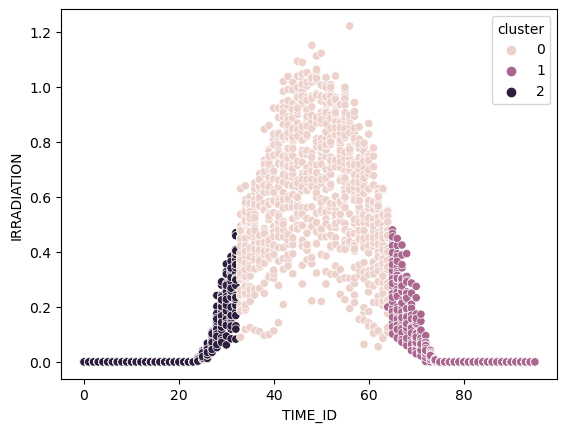

In [49]:
sns.scatterplot(data=X, x='TIME_ID', y='IRRADIATION', hue='cluster')

In [53]:
X['IrrMulATemp'] = X['AMBIENT_TEMPERATURE'] * X['IRRADIATION']

In [54]:
mutual_info_regression(X, y)

array([1.10396313, 1.00700208, 1.00741782, 0.56888828, 1.12034903])

In [55]:
X

,TIME_ID,AMBIENT_TEMPERATURE,IRRADIATION,cluster,IrrMulATemp
0,0,25.184316,0.0,2,0.0
1,0,24.170166,0.0,2,0.0
2,0,21.155691,0.0,2,0.0
3,0,22.610982,0.0,2,0.0
4,0,22.465285,0.0,2,0.0
...,...,...,...,...,...
3177,95,22.205029,0.0,1,0.0
3178,95,23.418154,0.0,1,0.0
3179,95,23.641211,0.0,1,0.0
3180,95,22.892004,0.0,1,0.0


c:\Users\Shadow\anaconda3\envs\tgpu\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


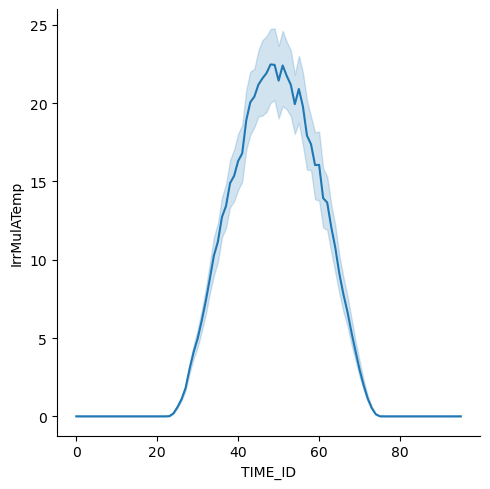

In [57]:
sns.relplot(data=X, kind='line', x='TIME_ID', y='IrrMulATemp')

In [62]:
pca = PCA()
X_pca = pca.fit_transform(X)
names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=names)

In [63]:
X_pca

,PC1,PC2,PC3,PC4,PC5
0,48.021264,-5.294469,3.189050,0.004676,-0.005439
1,48.061788,-5.578991,2.216882,0.031897,0.001975
2,48.182242,-6.424706,-0.672804,0.112809,0.024013
3,48.124091,-6.016422,0.722244,0.073748,0.013374
4,48.129912,-6.057297,0.582578,0.077658,0.014439
...,...,...,...,...,...
3177,-46.781124,-8.344845,-2.980759,-0.103034,0.017859
3178,-46.829599,-8.004501,-1.817854,-0.135596,0.008991
3179,-46.838512,-7.941922,-1.604031,-0.141583,0.007360
3180,-46.808575,-8.152113,-2.322223,-0.121473,0.012837


In [64]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=names, 
    index=X.columns
)

In [77]:
pd.DataFrame(pca.components_.T)
loadings

,PC1,PC2,PC3,PC4,PC5
TIME_ID,-0.999022,-0.023999,-0.034971,-0.012473,-0.000310
AMBIENT_TEMPERATURE,-0.039959,0.280551,0.958603,-0.026841,-0.007311
IRRADIATION,-0.000256,0.032089,-0.016208,0.029025,-0.998932
cluster,0.014325,-0.065349,-0.008436,-0.997244,-0.030942
IrrMulATemp,-0.012354,0.956773,-0.281998,-0.061529,0.033525


In [79]:
# To choose PC2 if adding to dataset or join both dataset (dunno why but why not)

I'm taking too long for this simple project, but here's a quick overview of what I'd need to do if we talk about features (as after the first feature engineering "exercice"):


    - Outliers, Missing values
        1. Discard them
        2. Train a model to fill them artificially
        3. Reimplement all values to train a new network for temp prediction

        
    - New model, new target
        1. Base on same "goals" as the current model, I won't be acounting days, but only quarter of hours
        2. INPUT: (Not precisely defined) Time Irradiation & Ambient temp OUTPUT: AC_OUTPUT
        3. Challenge: Link both datasets, re-engineering the features and fit a got algorithm to predict accurately the output 
        4. Bonus: Convert to full forecast for end of day.
        5. Note bene: Need to be carefull of "out-of-sun" hours

For outliers managements, I'll  focus on this part in **missliers.ipynb**.

For the "new models" will be in **model_output.ipynb**.
